In [1273]:
from mpmath import mp
import numpy as np
import torch
from typing import List
from multiprocessing import Pool
import os
from model import WDGRL
import matplotlib.pyplot as plt

mp.dps = 500
def gen_data(mu: float, delta: List[int], n: int, d: int):
    mu = np.full((n, d), mu, dtype=np.float64)
    noise = np.random.normal(loc = 0, scale = 1, size=(n, d))
    X = mu + noise
    labels = np.zeros(n)
    if len(delta) == 1:
        n_anomalies = int(n * 0.05)
        idx = np.random.choice(n, n_anomalies, replace=False)
        X[idx] = X[idx] + delta[0]
        if delta[0] != 0:
            labels[idx] = np.ones(n_anomalies)
    else:
        # In this case, we generate data for source domain.
        # 5% of the data is abnormal.
        # Anomalies are generated by randomly adding deltas to the data.
        n_anomalies = int(n * 0.05)
        idx = np.random.choice(n, n_anomalies, replace=False)
        if 0 in delta: 
            delta.pop(delta.index(0))
        if len(delta) != 0:
            split_points = sorted(np.random.choice(range(1, len(idx)), len(delta) - 1, replace=False))
            segments = np.split(idx, split_points)
            for i, segment in enumerate(segments):
                X[segment] = X[segment] + delta[i]
            labels[idx] = 1
    return X, labels


In [1274]:
import torch
import torch.nn as nn
from typing import List
class Generator(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Feature extractor network."""
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Domain critic network."""
        super().__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

from typing import Optional
import numpy as np
from tqdm.notebook import trange
from torch.utils.data import DataLoader

class WDGRL():
    def __init__(self, input_dim: int=2, generator_hidden_dims: List[int]=[32, 16, 8, 4, 2], critic_hidden_dims: List[int]=[32, 16, 8, 4, 2],
                 gamma: float = 0.1, _lr_generator: float = 1e-2, _lr_critic: float = 1e-2, 
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.gamma = gamma
        self.device = device
        self.generator = Generator(input_dim, generator_hidden_dims).to(self.device)
        self.critic = Critic(generator_hidden_dims[-1], critic_hidden_dims).to(self.device)
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=_lr_generator)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=_lr_critic)
    
    def compute_gradient_penalty(self, source_data: torch.Tensor, target_data: torch.Tensor) -> torch.Tensor:
        """Compute gradient penalty."""
        if source_data.size(0) > target_data.size(0):
            ms = source_data.size(0)
            mt = target_data.size(0)
            gradient_penalty = 0
            for _ in range(0, ms, mt):
                source_chunk = source_data[_:_+mt]
                target_chunk = target_data
                alpha = torch.rand(target_chunk.size(0), 1).to(self.device)
                interpolates = (alpha * source_chunk + ((1 - alpha) * target_chunk)).requires_grad_(True)
                
                # Domain critic outputs
                dc_output = self.critic(interpolates)
                
                # Compute gradients
                gradients = torch.autograd.grad(
                    outputs=dc_output,
                    inputs=interpolates,
                    grad_outputs=torch.ones_like(dc_output).to(self.device),
                    create_graph=True,
                    retain_graph=True,
                    only_inputs=True,
                )
                gradients = gradients[0]
                gradient_penalty += ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            if ms % mt != 0:
                source_chunk = source_data[ms-mt:]
                perm = torch.randperm(mt)
                idx = perm[:ms % mt]
                target_chunk = target_data[idx]
                alpha = torch.rand(target_chunk.size(0), 1).to(self.device)
                interpolates = (alpha * source_chunk + ((1 - alpha) * target_chunk)).requires_grad_(True)
                
                # Domain critic outputs
                dc_output = self.critic(interpolates)
                
                # Compute gradients
                gradients = torch.autograd.grad(
                    outputs=dc_output,
                    inputs=interpolates,
                    grad_outputs=torch.ones_like(dc_output).to(self.device),
                    create_graph=True,
                    retain_graph=True,
                    only_inputs=True,
                )
                gradients = gradients[0]
                gradient_penalty += ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            return gradient_penalty / ((ms // mt) + (ms % mt != 0)) 
        
        # For balanced batch
        alpha = torch.rand(source_data.size(0), 1).to(self.device)
        interpolates = (alpha * source_data + ((1 - alpha) * target_data)).requires_grad_(True)
        
        # Domain critic outputs
        dc_output = self.critic(interpolates)
        
        # Compute gradients
        gradients = torch.autograd.grad(
            outputs=dc_output,
            inputs=interpolates,
            grad_outputs=torch.ones_like(dc_output).to(self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        # Compute gradient penalty
        gradients = gradients.view(gradients.size(0), -1)
        return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    def train(self, source_loader: DataLoader, target_loader: DataLoader, num_epochs: int = 100, dc_iter: int = 100) -> List[float]:
        self.generator.train()
        self.critic.train()
        losses = []
        source_critic_scores = []
        target_critic_scores = []
        for epoch in trange(num_epochs, desc='Epoch'):
            loss = 0
            for (source_data, _), (target_data, _) in zip(source_loader, target_loader):
                source_data, target_data = source_data.to(self.device), target_data.to(self.device)

                # Train domain critic
                for _ in range(dc_iter):
                    self.critic_optimizer.zero_grad()
                    
                    with torch.no_grad():
                        source_features = self.generator(source_data)
                        target_features = self.generator(target_data)
                    
                    # Compute empirical Wasserstein distance
                    dc_source = self.critic(source_features)
                    dc_target = self.critic(target_features)
                    wasserstein_distance = dc_source.mean() - dc_target.mean()

                    # Gradient penalty
                    gradient_penalty = self.compute_gradient_penalty(source_features, target_features)

                    # Domain critic loss
                    dc_loss = - wasserstein_distance + self.gamma * gradient_penalty
                    dc_loss.backward()
                    self.critic_optimizer.step()

                # Train feature extractor
                self.generator_optimizer.zero_grad()
                source_features = self.generator(source_data)
                target_features = self.generator(target_data)
                dc_source = self.critic(source_features)
                dc_target = self.critic(target_features)
                wasserstein_distance = dc_source.mean() - dc_target.mean()
                wasserstein_distance.backward()
                self.generator_optimizer.step()
                
                with torch.no_grad():
                    loss += wasserstein_distance.item()
                    
            source_critic_scores.append(self.criticize(source_loader.dataset.tensors[0].to(self.device)))
            target_critic_scores.append(self.criticize(target_loader.dataset.tensors[0].to(self.device)))
            losses.append(loss/len(source_loader))
            print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {wasserstein_distance.item()}')
        return losses, source_critic_scores, target_critic_scores
    
    @torch.no_grad()
    def extract_feature(self, x: torch.Tensor) -> torch.Tensor:
        self.generator.eval()
        return self.generator(x)
    
    @torch.no_grad()
    def criticize(self, x: torch.Tensor) -> float:
        self.generator.eval()
        self.critic.eval()
        return self.critic(self.generator(x)).mean().item()

In [1275]:
d = 1
generator_hidden_dims = [4, 4, 2]
critic_hidden_dims = [4, 2, 1]
model = WDGRL(input_dim=d, generator_hidden_dims=generator_hidden_dims, critic_hidden_dims=critic_hidden_dims)
index = None
with open("model/models.txt", "r") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        words = line[:-1].split("/")
        if words[1] == str(generator_hidden_dims) and words[2] == str(critic_hidden_dims):
            index = i
            break
if index is None:
    print("Model not found")
    exit()
check_point = torch.load(f"model/wdgrl_{index}.pth", map_location=model.device, weights_only=True)
model.generator.load_state_dict(check_point['generator_state_dict'])
model.critic.load_state_dict(check_point['critic_state_dict'])

<All keys matched successfully>

In [1276]:
def intersect(itv1, itv2):
    # print(itv1, itv2)
    itv = [max(itv1[0], itv2[0]), min(itv1[1], itv2[1])]
    if itv[0] > itv[1]:
        return None    
    return itv

def solve_linear_inequality(u, v): #u + vz < 0
    u = float(u)
    v = float(v)
    # print(u, v)
    if (v > -1e-16 and v < 1e-16):
        if (u <= 0):
            return [-np.Inf, np.Inf]
        else:
            print('error', u, v)
            return None
    if (v < 0):
        return [-u/v, np.Inf]
    return [np.NINF, -u/v]

def get_dnn_interval(Xtj, a, b, model):
    layers = []

    for name, param in model.generator.named_children():
        temp = dict(param._modules)
        
        for layer_name in temp.values():
            if ('Linear' in str(layer_name)):
                layers.append('Linear')
            elif ('ReLU' in str(layer_name)):
                layers.append('ReLU')

    ptr = 0
    itv = [np.NINF, np.Inf]
    u = a
    v = b
    temp = Xtj
    weight = None
    bias = None
    for name, param in model.generator.named_parameters():
        if (layers[ptr] == 'Linear'):
            if ('weight' in name):
                weight = param.data.cpu().detach().numpy()
            elif ('bias' in name):
                bias = param.data.cpu().detach().numpy().reshape(-1, 1)
                ptr += 1
                temp = weight.dot(temp) + bias
                u = weight.dot(u) + bias
                v = weight.dot(v)

        if (ptr < len(layers) and layers[ptr] == 'ReLU'):
            ptr += 1
            Relu_matrix = np.zeros((temp.shape[0], temp.shape[0]))
            sub_itv = [np.NINF, np.inf]
            for i in range(temp.shape[0]):
                if temp[i] > 0:
                    Relu_matrix[i][i] = 1
                    sub_itv = intersect(sub_itv, solve_linear_inequality(-u[i], -v[i]))
                else:
                    sub_itv = intersect(sub_itv, solve_linear_inequality(u[i], v[i]))
            itv = intersect(itv, sub_itv)
            temp = Relu_matrix.dot(temp)
            u = Relu_matrix.dot(u)
            v = Relu_matrix.dot(v)
    return itv, u[:, 0], v[:, 0]

def median(a):
    return np.argsort(a)[len(a) // 2]

def MAD_AD(Xs, Xt, alpha):
    O = []
    X = np.concatenate((Xs, Xt), axis=0)
    for i in range(X.shape[1]):
        median1 = median(X[:, i])
        absolute_deviation = np.abs(X[:, i] - X[median1, i])
        median2 = median(absolute_deviation)
        
        lower = X[median1, i] - alpha*absolute_deviation[median2]
        upper = X[median1, i] + alpha*absolute_deviation[median2]
        for j in range(Xt.shape[0]):
            if j not in O and ((Xt[j, i] < lower) or (Xt[j, i] > upper)):
                O.append(j)
    return np.sort(O)

def get_ad_interval(X, X_hat, ns, nt, O, a, b, model, alpha):
    itv = [np.NINF, np.Inf]
    u = np.zeros((X.shape[0], X_hat.shape[1]))
    v = np.zeros((X.shape[0], X_hat.shape[1]))
    print(u.shape, v.shape)
    for i in range(X_hat.shape[0]):
        sub_itv, u[i], v[i] = get_dnn_interval(X[i].reshape(-1, 1), a[i].reshape(-1, 1), b[i].reshape(-1, 1), model)
        itv = intersect(itv, sub_itv)
    # print(u, v)
    for d in range(X_hat.shape[1]):
        k1 = median(X_hat[:, d])
        for i in range(X_hat.shape[0]):
            if X_hat[i, d] <= X_hat[k1, d]:
                itv = intersect(itv, solve_linear_inequality(u[i, d] - u[k1, d], v[i, d] - v[k1, d]))
            else:
                itv = intersect(itv, solve_linear_inequality(u[k1, d] - u[i, d], v[k1, d] - v[i, d]))
        dev = np.abs(X_hat[:, d] - X_hat[k1, d])
        k2 = median(dev)
        sk2 = np.sign(X_hat[k2, d] - X_hat[k1, d])
        for j in range(X_hat.shape[0]):
            if abs(X_hat[j, d] - X_hat[k1, d]) <= abs(X_hat[k2, d] - X_hat[k1, d]):
                sj = np.sign(X_hat[j, d] - X_hat[k1, d])
                itv = intersect(itv, solve_linear_inequality(
                    sj * (u[j, d] - u[k1, d]) - sk2 * (u[k2, d] - u[k1, d]), 
                    sj * (v[j, d] - v[k1, d]) - sk2 * (v[k2, d] - v[k1, d])))
            else:
                sj = np.sign(X_hat[j, d] - X_hat[k1, d])
                itv = intersect(itv, solve_linear_inequality(
                    -sj * (u[j, d] - u[k1, d]) + sk2 * (u[k2, d] - u[k1, d]), 
                    -sj * (v[j, d] - v[k1, d]) + sk2 * (v[k2, d] - v[k1, d])))
                
        upper = X_hat[k1, d] + alpha * dev[k2]
        lower = X_hat[k1, d] - alpha * dev[k2]
        for j in range(ns, X.shape[0]):
            if (X_hat[j, d] < lower):
                itv = intersect(itv, solve_linear_inequality(
                    u[j, d] - u[k1, d] + alpha * sk2 * (u[k2, d] - u[k1, d]),
                    v[j, d] - v[k1, d] + alpha * sk2 * (v[k2, d] - v[k1, d])
                ))
            elif (X_hat[j, d] > upper):
                itv = intersect(itv, solve_linear_inequality(
                    -(u[j, d] - u[k1, d] - alpha * sk2 * (u[k2, d] - u[k1, d])),
                    -(v[j, d] - v[k1, d] - alpha * sk2 * (v[k2, d] - v[k1, d]))
                ))

    return itv

def compute_yz(X, etaj, zk, n):
    sq_norm = (np.linalg.norm(etaj))**2

    e1 = np.identity(n) - (np.dot(etaj, etaj.T))/sq_norm
    a = np.dot(e1, X)

    b = etaj/sq_norm

    Xz = a + b*zk

    return Xz, a, b

def max_sum(X):
    return 0

def parametric_wdgrl(Xz, a, b, n, zk, model):
    Xz = torch.FloatTensor(Xz)
    Xz_hat = model.extract_feature(Xz.cuda())
    Oz = [max_sum(Xz_hat.cpu().numpy())]
    itv = get_ad_interval(Xz, Xz_hat, Oz[0], a, b, model)
    return itv[1] - min(zk, itv[1]), Oz


def run_parametric_wdgrl(X, etaj, n, threshold, model, ns):
    zk = -threshold

    list_zk = [zk]
    list_Oz = []

    while zk < threshold:
        Xz, a, b = compute_yz(X, etaj, zk, n)
        skz, Oz = parametric_wdgrl(Xz, a, b, n, zk, model)
        zk = zk + skz + 1e-3 
        # zk = min(zk, threshold)
        if zk < threshold:
            list_zk.append(zk)
        else:
            list_zk.append(threshold)
        list_Oz.append(Oz)
        # print(f'intervals: {zk-skz-1e-3} - {zk -1e-3}')
        # print(f'Anomaly index: {Oz}')
        # print('-------------')
    return list_zk, list_Oz
        
def cdf(mu, sigma, list_zk, list_Oz, etajTX, O):
    numerator = 0
    denominator = 0
    for each_interval in range(len(list_zk) - 1):
        al = list_zk[each_interval]
        ar = list_zk[each_interval + 1] - 1e-3

        if (np.array_equal(O, list_Oz[each_interval]) == False):
            continue

        denominator = denominator + mp.ncdf((ar - mu)/sigma) - mp.ncdf((al - mu)/sigma)
        if etajTX >= ar:
            numerator = numerator + mp.ncdf((ar - mu)/sigma) - mp.ncdf((al - mu)/sigma)
        elif (etajTX >= al) and (etajTX< ar):
            numerator = numerator + mp.ncdf((etajTX - mu)/sigma) - mp.ncdf((al - mu)/sigma)
    # print(f'numerator: {numerator}')
    # print(f'denominator: {denominator}')
    if denominator != 0:
        return float(numerator/denominator)
    else:
        return None

def get_interval(Xtj, a, b, model):
    layers = []

    for name, param in model.generator.named_children():
        temp = dict(param._modules)
        
        for layer_name in temp.values():
            if ('Linear' in str(layer_name)):
                layers.append('Linear')
            elif ('ReLU' in str(layer_name)):
                layers.append('ReLU')

    ptr = 0
    itv = [np.NINF, np.Inf]
    u = a
    v = b
    temp = Xtj
    weight = None
    bias = None
    for name, param in model.generator.named_parameters():
        if (layers[ptr] == 'Linear'):
            if ('weight' in name):
                weight = param.data.cpu().detach().numpy()
            elif ('bias' in name):
                bias = param.data.cpu().detach().numpy().reshape(-1, 1)
                ptr += 1
                temp = weight.dot(temp) + bias
                u = weight.dot(u) + bias
                v = weight.dot(v)

        if (ptr < len(layers) and layers[ptr] == 'ReLU'):
            ptr += 1
            Relu_matrix = np.zeros((temp.shape[0], temp.shape[0]))
            sub_itv = [np.NINF, np.inf]
            for i in range(temp.shape[0]):
                if temp[i] > 0:
                    Relu_matrix[i][i] = 1
                    sub_itv = intersect(sub_itv, solve_linear_inequality(-u[i][0], -v[i][0]))
                else:
                    sub_itv = intersect(sub_itv, solve_linear_inequality(u[i][0], v[i][0]))
            itv = intersect(itv, sub_itv)
            temp = Relu_matrix.dot(temp)
            u = Relu_matrix.dot(u)
            v = Relu_matrix.dot(v)

    return itv, u, v

def truncated_cdf(etajTy, mu, sigma, left, right):
    numerator = mp.ncdf((etajTy - mu) / sigma) - mp.ncdf((left - mu) / sigma)
    denominator = mp.ncdf((right - mu) / sigma) - mp.ncdf((left - mu) / sigma)
    # print(f'numerator: {numerator}')
    # print(f'denominator: {denominator}')
    if denominator != 0:
        return float(numerator/denominator)
    else:
        return None

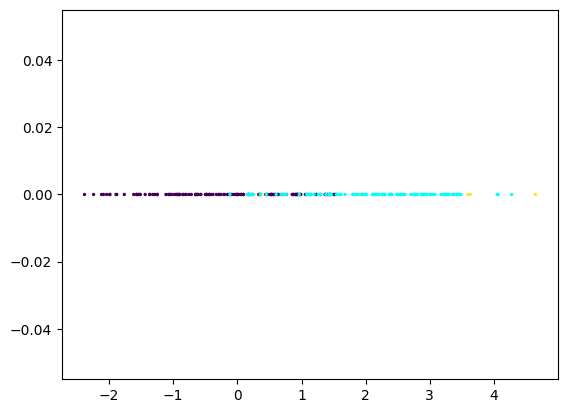

In [1277]:
ns, nt, d = 150, 100, 1
mu_s, mu_t = 0, 2
delta_s, delta_t = [0, 1, 2, 3, 4], [0]
xs, ys = gen_data(mu_s, delta_s, ns, d)
xt, yt = gen_data(mu_t, delta_t, nt, d)
plt.scatter(xs[:, 0], np.zeros_like(xs[:, 0]), c=ys, cmap='viridis', s=2)
plt.scatter(xt[:, 0], np.zeros_like(xt[:, 0]), c=yt, cmap='cool', s=2)
plt.show()

In [1278]:
xs = torch.FloatTensor(xs)
ys = torch.LongTensor(ys)
xt = torch.FloatTensor(xt)
yt = torch.LongTensor(yt)
xs_hat = model.extract_feature(xs.cuda())
xt_hat = model.extract_feature(xt.cuda())
x_hat = torch.cat([xs_hat, xt_hat], dim=0)

xs_hat = xs_hat.cpu()
xt_hat = xt_hat.cpu()
x_hat = x_hat.cpu()
xs = xs.cpu()
xt = xt.cpu()
ys = ys.cpu()
yt = yt.cpu()

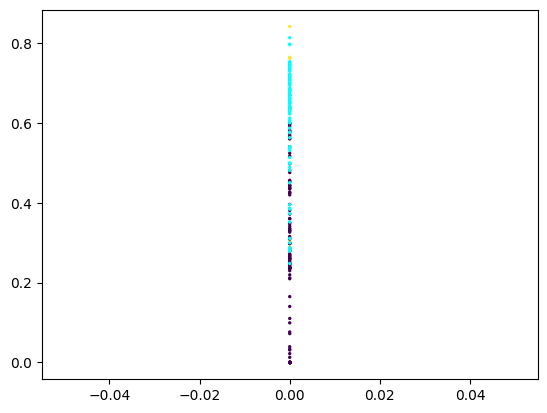

In [1279]:
plt.scatter(xs_hat[:, 0], xs_hat[:, 1], c=ys, cmap='viridis', s=2)
plt.scatter(xt_hat[:, 0], xt_hat[:, 1], c=yt, cmap='cool', s=2)
plt.show()

In [1280]:
alpha = 1.5
O = MAD_AD(xs_hat.numpy(), xt_hat.numpy(), alpha)
print(O)
print(O.shape)

[ 1 19 21 31 32 37 48 51 52 55 57 60 61 62 71 73 76 77 78 86 87 88 89 90
 94 95 99]
(27,)


In [1281]:
yt_hat = torch.zeros_like(yt)
yt_hat[O] = 1

print(yt)
print(yt_hat)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 1])


In [ ]:
Oc = list(np.where(yt_hat == 0)[0])
j = np.random.choice(O, 1, replace=False)[0]
etj = np.zeros((nt, 1))
etj[j][0] = 1
etOc = np.zeros((nt, 1))
etOc[Oc] = 1
etaj = np.vstack((np.zeros((ns, 1)), etj-(1/len(Oc))*etOc))
X = np.vstack((xs.numpy(), xt.numpy()))

etajTX = etaj.T.dot(X)
# print(f'etajTX: {etajTX}')
mu = np.vstack((np.full((ns,1), mu_s), np.full((nt,1), mu_t)))
sigma = np.identity(ns+nt)
etajTmu = etaj.T.dot(mu)
etajTsigmaetaj = etaj.T.dot(sigma).dot(etaj)

b = sigma.dot(etaj).dot(np.linalg.inv(etajTsigmaetaj))
a = (np.identity(ns+nt) - b.dot(etaj.T)).dot(X)
j = j + ns
itv = get_ad_interval(X, x_hat, ns, nt, O, a, b, model, alpha)
print(itv)
cdf = truncated_cdf(etajTX[0][0], etajTmu[0][0], np.sqrt(etajTsigmaetaj[0][0]), itv[0], itv[1])
p_value = float(2 * min(cdf, 1 - cdf))
print(f'p_value: {p_value}')

(250, 2) (250, 2)


C:\Users\Admin\AppData\Local\Temp\ipykernel_9452\449440763.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(u)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9452\449440763.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = float(v)


[1.133033489853922, 1.5328072063051799]
p_value: 0.012506559231394654


: 